In [2]:
#Capstone 2
#Preprocessing and training (revised)

In [3]:
#imports
import pandas as pd
import numpy as np
import datetime as dt

# Import regression modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from scipy.stats import expon
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Show plots inline
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
mpl.style.reload_library()
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.metrics import accuracy_score, f1_score

In [5]:
#!pip install pyxlsb

In [6]:
df_data = pd.read_csv('healthcare_homeless_cleaned.csv')
#cali_df = pd.read_csv('% cumulative change in homelessness in ca.csv')

In [7]:
df_data = df_data[['Year', 'Overall Homeless', 'Housing Prices', 'Unemployment rate', 'Obama ACA Indicator', 'CPI California, Urban Consumers', 'Healthcare Cost, California']]
df_data = df_data.rename(columns = {'Overall Homeless':'Overall Homeless LA'})
df_data

,Year,Overall Homeless LA,Housing Prices,Unemployment rate,Obama ACA Indicator,"CPI California, Urban Consumers","Healthcare Cost, California"
0,2007,71320,254.0,5.1,0.0,217.0,209334.000000
1,2008,65111,208.0,7.5,0.0,225.0,220894.000000
2,2009,33243,176.0,11.7,0.0,224.0,229415.000000
3,2010,63706,174.0,12.6,1.0,227.0,241845.000000
4,2011,56257,166.0,12.2,1.0,233.0,253703.000000
5,2012,49955,165.0,11.0,1.0,238.0,267048.000000
6,2013,52442,180.0,9.8,1.0,242.0,277008.000000
7,2014,43854,204.0,8.2,1.0,246.0,288330.000000
8,2015,41174,216.0,6.7,1.0,250.0,311146.000000
9,2016,34393,232.0,5.3,1.0,255.0,325931.000000


In [8]:
# Initialize an empty list to store DataFrames from each sheet
ca_list = []

# Loop through each sheet (0 to 16)
for i in range(0, 17):
    # Load each sheet into a DataFrame
    state_data = pd.read_excel('/Users/ofrioren/GIT/Capstone/data/2007-2023-PIT-Counts-by-CoC.xlsb', sheet_name=i)
    
    # Filter rows where the 'CoC Number' starts with 'CA-'
    ca_data = state_data[state_data['CoC Number'].fillna('').str.startswith('CA-')]
    
    # Select relevant columns (only keep 'CoC Name' in the first iteration)
    if i == 0:
        ca_data = ca_data[['CoC Number', 'CoC Name', 'Overall Homeless']]
    else:
        ca_data = ca_data[['CoC Number', 'Overall Homeless']]
    
    # Rename the 'Overall Homeless' column to include the year (i.e., sheet index)
    ca_data.rename(columns={'Overall Homeless': f'Overall Homeless {2007 + i}'}, inplace=True)
    
    # Append the filtered data to the list
    ca_list.append(ca_data)

# Merge all sheets on 'CoC Number'
ca_years = ca_list[0]  # Initialize the final DataFrame with the first DataFrame in the list
for ca_data in ca_list[1:]:
    ca_years = pd.merge(ca_years, ca_data, on='CoC Number', how='left')

# Display the final merged DataFrame
print(ca_years.head())


  CoC Number                                CoC Name  Overall Homeless 2007  \
0     CA-500  San Jose/Santa Clara City & County CoC                 9903.0   
1     CA-501                       San Francisco CoC                 7582.0   
2     CA-502    Oakland, Berkeley/Alameda County CoC                 9759.0   
3     CA-503            Sacramento City & County CoC                 9281.0   
4     CA-504  Santa Rosa, Petaluma/Sonoma County CoC                 2266.0   

   Overall Homeless 2008  Overall Homeless 2009  Overall Homeless 2010  \
0                10028.0                 2301.0                 9605.0   
1                 7754.0                 4000.0                 8124.0   
2                 9747.0                 2546.0                 8137.0   
3                 9278.0                 1885.0                 5511.0   
4                 2893.0                  787.0                 2745.0   

   Overall Homeless 2011  Overall Homeless 2012  Overall Homeless 2013  \
0     

In [9]:
ca_years.isna().sum()

CoC Number               0
CoC Name                 0
Overall Homeless 2007    0
Overall Homeless 2008    0
Overall Homeless 2009    0
Overall Homeless 2010    0
Overall Homeless 2011    0
Overall Homeless 2012    1
Overall Homeless 2013    1
Overall Homeless 2014    1
Overall Homeless 2015    1
Overall Homeless 2016    4
Overall Homeless 2017    4
Overall Homeless 2018    4
Overall Homeless 2019    4
Overall Homeless 2020    4
Overall Homeless 2021    4
Overall Homeless 2022    4
Overall Homeless 2023    4
dtype: int64

In [10]:
numeric_cols = ca_years.select_dtypes(include='number')
non_numeric_cols = ca_years.select_dtypes(exclude='number')

# Fill missing values in numeric columns with the row mean
numeric_filled = numeric_cols.apply(lambda row: row.fillna(row.mean()), axis=1)

# Concatenate back the non-numeric columns with the filled numeric columns
ca_years_filled = pd.concat([non_numeric_cols, numeric_filled], axis=1)

# Check that there are no missing values
ca_years_filled.isna().sum()

CoC Number               0
CoC Name                 0
Overall Homeless 2007    0
Overall Homeless 2008    0
Overall Homeless 2009    0
Overall Homeless 2010    0
Overall Homeless 2011    0
Overall Homeless 2012    0
Overall Homeless 2013    0
Overall Homeless 2014    0
Overall Homeless 2015    0
Overall Homeless 2016    0
Overall Homeless 2017    0
Overall Homeless 2018    0
Overall Homeless 2019    0
Overall Homeless 2020    0
Overall Homeless 2021    0
Overall Homeless 2022    0
Overall Homeless 2023    0
dtype: int64

In [11]:
print(ca_years_filled.head())

  CoC Number                                CoC Name  Overall Homeless 2007  \
0     CA-500  San Jose/Santa Clara City & County CoC                 9903.0   
1     CA-501                       San Francisco CoC                 7582.0   
2     CA-502    Oakland, Berkeley/Alameda County CoC                 9759.0   
3     CA-503            Sacramento City & County CoC                 9281.0   
4     CA-504  Santa Rosa, Petaluma/Sonoma County CoC                 2266.0   

   Overall Homeless 2008  Overall Homeless 2009  Overall Homeless 2010  \
0                10028.0                 2301.0                 9605.0   
1                 7754.0                 4000.0                 8124.0   
2                 9747.0                 2546.0                 8137.0   
3                 9278.0                 1885.0                 5511.0   
4                 2893.0                  787.0                 2745.0   

   Overall Homeless 2011  Overall Homeless 2012  Overall Homeless 2013  \
0     

In [12]:
unemployment = pd.read_csv('/Users/ofrioren/GIT/Capstone/data/CA UR statewide.csv')
housing_prices = pd.read_csv('/Users/ofrioren/GIT/Capstone/data/CA all housing prices.csv')

In [13]:
import pandas as pd

# Initialize an empty list to store DataFrames from each sheet
homeless_list = []

# Loop through each sheet (1 to 16), page zero has other information
for i in range(1, 17):
    # Load each sheet into a DataFrame
    statewide_homeless = pd.read_excel('/Users/ofrioren/GIT/Capstone/data/2007-2023-PIT-Counts-by-State.xlsb', sheet_name=i)
    
    # Filter rows where the state is CA
    homeless_data = statewide_homeless[statewide_homeless['State'] == 'CA']
    
    # Select relevant columns, including 'State' for the merge
    homeless_data = homeless_data[['State', 'Overall Homeless']]
    
    # Rename the 'Overall Homeless' column to include the year (i.e., sheet index)
    homeless_data.rename(columns={'Overall Homeless': f'Overall Homeless {2007 + i}'}, inplace=True)
    
    # Append the filtered data to the list
    homeless_list.append(homeless_data)

# Merge all sheets on 'State' using the first DataFrame as the base
homeless_years = homeless_list[0]  # Initialize the final DataFrame with the first DataFrame in the list
for homeless_data in homeless_list[1:]:
    homeless_years = pd.merge(homeless_years, homeless_data, on='State', how='left')

# Display the final merged DataFrame
homeless_years


,State,Overall Homeless 2008,Overall Homeless 2009,Overall Homeless 2010,Overall Homeless 2011,Overall Homeless 2012,Overall Homeless 2013,Overall Homeless 2014,Overall Homeless 2015,Overall Homeless 2016,Overall Homeless 2017,Overall Homeless 2018,Overall Homeless 2019,Overall Homeless 2020,Overall Homeless 2021,Overall Homeless 2022,Overall Homeless 2023
0,CA,181399,171521,57468,161548,151278,129972,131532,118142,115738,113952,118552,120098,125128,123480,123678,136531


In [14]:
overall_homeless = homeless_years.T
overall_homeless

,0
State,CA
Overall Homeless 2008,181399
Overall Homeless 2009,171521
Overall Homeless 2010,57468
Overall Homeless 2011,161548
Overall Homeless 2012,151278
Overall Homeless 2013,129972
Overall Homeless 2014,131532
Overall Homeless 2015,118142
Overall Homeless 2016,115738


In [15]:
# Reset index to ensure it's unique
overall_homeless.reset_index(drop=True, inplace=True)

# Create a list of years from 2007 to 2023
years = [2007] + list(range(2008, 2024))

# Create a DataFrame for years
years_df = pd.DataFrame({'Year': years})

overall_homeless['Year'] = years_df

overall_homeless


,0,Year
0,CA,2007
1,181399,2008
2,171521,2009
3,57468,2010
4,161548,2011
5,151278,2012
6,129972,2013
7,131532,2014
8,118142,2015
9,115738,2016


In [16]:
overall_homeless = overall_homeless.rename(columns={0: 'Overall Homeless CA'})
overall_homeless['Overall Homeless CA'] = pd.to_numeric(overall_homeless['Overall Homeless CA'], errors='coerce')
overall_homeless = overall_homeless.fillna(138986)
overall_homeless

,Overall Homeless CA,Year
0,138986.0,2007
1,181399.0,2008
2,171521.0,2009
3,57468.0,2010
4,161548.0,2011
5,151278.0,2012
6,129972.0,2013
7,131532.0,2014
8,118142.0,2015
9,115738.0,2016


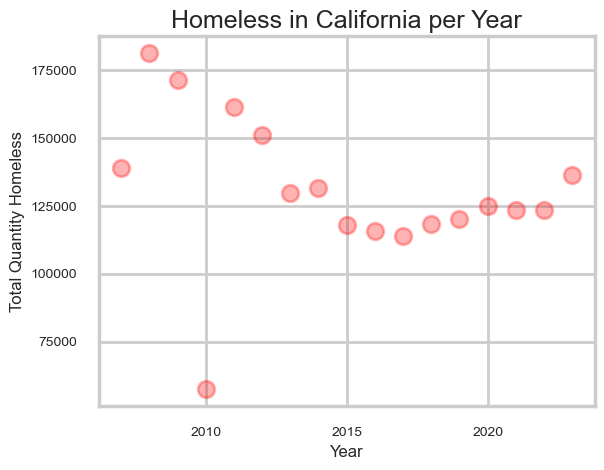

In [118]:
plt.scatter(x=overall_homeless['Year'], y=overall_homeless['Overall Homeless CA'], c='r', alpha=0.3)
plt.title('Homeless in California per Year', size=18)
plt.xlabel('Year', size=12)
plt.ylabel('Total Quantity Homeless', size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.savefig('Overall Homelessness in California per Year.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [17]:
data = df_data.drop('Overall Homeless LA', axis=1)
data = data.rename(columns={'Housing Prices':'Housing prices LA', 'Unemployment rate':'Unemployment rate LA'})
data['CA unemployment rate'] = unemployment['CAUR']
data['CA Housing prices'] = housing_prices['CASTHPI']
data['Overall Homeless CA'] = overall_homeless['Overall Homeless CA']
data

,Year,Housing prices LA,Unemployment rate LA,Obama ACA Indicator,"CPI California, Urban Consumers","Healthcare Cost, California",CA unemployment rate,CA Housing prices,Overall Homeless CA
0,2007,254.0,5.1,0.0,217.0,209334.000000,5.3083333333333333,608.2850,138986.0
1,2008,208.0,7.5,0.0,225.0,220894.000000,7.3000000000000000,486.7400,181399.0
2,2009,176.0,11.7,0.0,224.0,229415.000000,11.5416666666666667,421.2925,171521.0
3,2010,174.0,12.6,1.0,227.0,241845.000000,12.4583333333333333,408.6300,57468.0
4,2011,166.0,12.2,1.0,233.0,253703.000000,11.8916666666666667,387.3250,161548.0
5,2012,165.0,11.0,1.0,238.0,267048.000000,10.5250000000000000,388.3900,151278.0
6,2013,180.0,9.8,1.0,242.0,277008.000000,9.0333333333333333,435.8875,129972.0
7,2014,204.0,8.2,1.0,246.0,288330.000000,7.5666666666666667,487.8550,131532.0
8,2015,216.0,6.7,1.0,250.0,311146.000000,6.2250000000000000,522.4900,118142.0
9,2016,232.0,5.3,1.0,255.0,325931.000000,5.5166666666666667,559.4450,115738.0


In [18]:
# Define the original column names
original_columns = [
    'Overall Homeless 2007', 'Overall Homeless 2008', 'Overall Homeless 2009',
    'Overall Homeless 2010', 'Overall Homeless 2011', 'Overall Homeless 2012',
    'Overall Homeless 2013', 'Overall Homeless 2014', 'Overall Homeless 2015',
    'Overall Homeless 2016', 'Overall Homeless 2017', 'Overall Homeless 2018',
    'Overall Homeless 2019', 'Overall Homeless 2020', 'Overall Homeless 2021',
    'Overall Homeless 2022', 'Overall Homeless 2023'
]

# Create a mapping from original column names to just the year
new_column_names = {col: col.split()[-1] for col in original_columns}

# Rename the columns in the DataFrame
df = ca_years_filled.rename(columns=new_column_names)

# Display the updated DataFrame
print(df.head())

  CoC Number                                CoC Name    2007     2008    2009  \
0     CA-500  San Jose/Santa Clara City & County CoC  9903.0  10028.0  2301.0   
1     CA-501                       San Francisco CoC  7582.0   7754.0  4000.0   
2     CA-502    Oakland, Berkeley/Alameda County CoC  9759.0   9747.0  2546.0   
3     CA-503            Sacramento City & County CoC  9281.0   9278.0  1885.0   
4     CA-504  Santa Rosa, Petaluma/Sonoma County CoC  2266.0   2893.0   787.0   

     2010    2011    2012    2013    2014    2015    2016    2017    2018  \
0  9605.0  9706.0  7254.0  7394.0  6524.0  6556.0  7567.0  7631.0  7053.0   
1  8124.0  8035.0  6857.0  6858.0  6996.0  6775.0  6408.0  7008.0  5895.0   
2  8137.0  8022.0  5496.0  5629.0  4145.0  4040.0  4272.0  4264.0  4257.0   
3  5511.0  5561.0  3621.0  3665.0  2500.0  2659.0  2449.0  2538.0  2812.0   
4  2745.0  2951.0  2996.0  2835.0  2906.0  3097.0  4266.0  4280.0  4483.0   

     2019    2020    2021    2022    2023  
0  706

In [19]:
transposed_df = data.transpose()

#Reset the first row as column names
transposed_df.columns = transposed_df.iloc[0]  

#Remove the first row (now used as column headers)
transposed_df = transposed_df.drop(transposed_df.index[0])
transposed_df = transposed_df.reset_index()

transposed_df

Year,index,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Housing prices LA,254.0,208.0,176.0,174.0,166.0,165.0,180.0,204.0,216.0,232.0,248.0,265.0,274.0,281.0,314.0,363.0,375.0
1,Unemployment rate LA,5.1,7.5,11.7,12.6,12.2,11.0,9.8,8.2,6.7,5.3,4.8,4.7,4.5,12.4,9.0,5.0,5.0
2,Obama ACA Indicator,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
3,"CPI California, Urban Consumers",217.0,225.0,224.0,227.0,233.0,238.0,242.0,246.0,250.0,255.0,263.0,273.0,281.0,285.0,297.0,319.0,332.0
4,"Healthcare Cost, California",209334.0,220894.0,229415.0,241845.0,253703.0,267048.0,277008.0,288330.0,311146.0,325931.0,338088.0,357648.0,379715.0,405451.0,426104.67394,447810.446031,470621.910151
5,CA unemployment rate,5.3083333333333333,7.3000000000000000,11.5416666666666667,12.4583333333333333,11.8916666666666667,10.5250000000000000,9.0333333333333333,7.5666666666666667,6.2250000000000000,5.5166666666666667,4.8333333333333333,4.2583333333333333,4.1000000000000000,10.1916666666666667,7.3250000000000000,4.2750000000000000,4.7416666666666667
6,CA Housing prices,608.285,486.74,421.2925,408.63,387.325,388.39,435.8875,487.855,522.49,559.445,596.04,634.745,655.27,683.09,779.145,900.0,915.81
7,Overall Homeless CA,138986.0,181399.0,171521.0,57468.0,161548.0,151278.0,129972.0,131532.0,118142.0,115738.0,113952.0,118552.0,120098.0,125128.0,123480.0,123678.0,136531.0


In [20]:
df_subset = df.drop(columns=['CoC Name'])
df_subset = df_subset.rename(columns={'CoC Number': 'index'})
df_subset.columns

Index(['index', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
      dtype='object')

In [100]:
df_subset = df_subset.rename(columns={'YearColumnInDfSubset': 'YearColumnInTransposedDf'})
df_subset.columns

Index(['index',    2007,    2008,    2009,    2010,    2011,    2012,    2013,
          2014,    2015,    2016,    2017,    2018,    2019,    2020,    2021,
          2022,    2023],
      dtype='object')

In [23]:
new_df = pd.concat([transposed_df, df_subset], axis=0)
new_df

,index,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Housing prices LA,254.0,208.0,176.0,174.0,166.0,165.0,180.0,204.0,216.0,232.0,248.0,265.0,274.0,281.0,314.0,363.0,375.0
1,Unemployment rate LA,5.1,7.5,11.7,12.6,12.2,11.0,9.8,8.2,6.7,5.3,4.8,4.7,4.5,12.4,9.0,5.0,5.0
2,Obama ACA Indicator,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
3,"CPI California, Urban Consumers",217.0,225.0,224.0,227.0,233.0,238.0,242.0,246.0,250.0,255.0,263.0,273.0,281.0,285.0,297.0,319.0,332.0
4,"Healthcare Cost, California",209334.0,220894.0,229415.0,241845.0,253703.0,267048.0,277008.0,288330.0,311146.0,325931.0,338088.0,357648.0,379715.0,405451.0,426104.67394,447810.446031,470621.910151
5,CA unemployment rate,5.3083333333333333,7.3000000000000000,11.5416666666666667,12.4583333333333333,11.8916666666666667,10.5250000000000000,9.0333333333333333,7.5666666666666667,6.2250000000000000,5.5166666666666667,4.8333333333333333,4.2583333333333333,4.1000000000000000,10.1916666666666667,7.3250000000000000,4.2750000000000000,4.7416666666666667
6,CA Housing prices,608.285,486.74,421.2925,408.63,387.325,388.39,435.8875,487.855,522.49,559.445,596.04,634.745,655.27,683.09,779.145,900.0,915.81
7,Overall Homeless CA,138986.0,181399.0,171521.0,57468.0,161548.0,151278.0,129972.0,131532.0,118142.0,115738.0,113952.0,118552.0,120098.0,125128.0,123480.0,123678.0,136531.0
0,CA-500,9903.0,10028.0,2301.0,9605.0,9706.0,7254.0,7394.0,6524.0,6556.0,7567.0,7631.0,7053.0,7067.0,7086.0,7086.0,7202.0,7202.0
1,CA-501,7582.0,7754.0,4000.0,8124.0,8035.0,6857.0,6858.0,6996.0,6775.0,6408.0,7008.0,5895.0,5669.0,5823.0,5823.0,5171.0,5703.0


In [24]:
#I need to select just the numeric rows and split them into my test and train sets.

# Select only numeric columns from the DataFrame
numeric_cols = new_df.select_dtypes(include=['float64', 'int64']).columns

# Create a subset of the DataFrame with only numeric columns
X = new_df.drop(['index', '2023'], axis=1)
y = new_df['2023']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the numeric columns
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=.2, random_state=42)

print(X_train.head())
print(y_train.head())

        2007      2008      2009      2010      2011      2012      2013  \
0  -0.008730 -0.026103 -0.168222  0.020995 -0.029295 -0.079141 -0.071376   
18 -0.257936 -0.251490 -0.217266 -0.223092 -0.237380 -0.225393 -0.218598   
6  -0.274879 -0.269122 -0.216640 -0.244872 -0.255955 -0.243078 -0.237619   
26 -0.271366 -0.265601 -0.223602 -0.232575 -0.244823 -0.242848 -0.239265   
4   5.701886  5.344720  5.681910  6.735061  5.905492  6.124213  6.370241   

        2014      2015      2016      2017      2018      2019      2020  \
0  -0.089102 -0.087145 -0.067180 -0.069744 -0.086887 -0.092075 -0.095959   
18 -0.214244 -0.207819 -0.200471 -0.199544 -0.212415 -0.212006 -0.204358   
6  -0.228831 -0.220153 -0.216103 -0.214641 -0.212166 -0.210414 -0.206886   
26 -0.225495 -0.222192 -0.219874 -0.219173 -0.217158 -0.215015 -0.213714   
4   6.434342  6.627498  6.698634  6.736576  6.756437  6.785763  6.805491   

        2021      2022  
0  -0.097915 -0.102064  
18 -0.201558 -0.184856  
6  -0.20238

In [25]:
#I have the data ready for a modelling pipeline now. I'll first just try a linear regression.

In [54]:
# Initialize and train the model
linear = LinearRegression()
linear.fit(X_scaled_df, y)

# Predict the values using the entire dataset
y_pred = linear.predict(X_scaled_df)

# Display coefficients
coef_df = pd.DataFrame({'features': X.columns, 'estimatedCoefficients': linear.coef_})[['features', 'estimatedCoefficients']]
print(coef_df)

   features  estimatedCoefficients
0      2007            -291.768171
1      2008            1288.127139
2      2009            4269.859121
3      2010            4510.200975
4      2011           -6475.972005
5      2012           12784.012888
6      2013          -13010.475202
7      2014           10783.210194
8      2015          -20788.084878
9      2016           28126.261141
10     2017          -17363.935783
11     2018          -20380.865536
12     2019           14515.344353
13     2020          -26660.899791
14     2021           37773.843160
15     2022           58134.896618


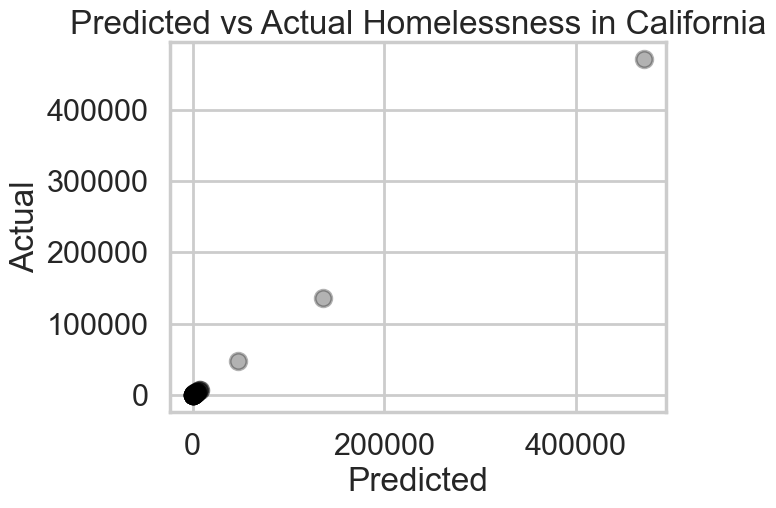

In [76]:
plt.scatter(x=y_pred, y=y, c='k', alpha=0.3)
plt.title('Predicted vs Actual Homelessness in California')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [81]:
# I will next use PCA analysis and create a pipeline for modelling in the next section.

new_df.to_csv('new_df.csv')


